In [88]:
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.use('Agg')
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# 数据增强
common_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Resize((224, 224))]
)

transform = {
    "training": transforms.Compose(
        [
            transforms.RandAugment(
                num_ops=4,
                magnitude=7,
                interpolation=transforms.InterpolationMode.BILINEAR,
                fill=None
            ),
            transforms.RandomHorizontalFlip(),
            # transforms.TrivialAugmentWide(),
            common_transforms,
        ]
    ),
    "evaluate": common_transforms,
}


def imshow_with_labels(images, labels, classes):
    num_images = len(images)
    grid_size = int(np.ceil(np.sqrt(num_images)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.flatten()

    for i in range(grid_size**2):
        if i < num_images:
            # img = to_pil_image(images[i])
            # extract that image (need to transpose it back to 32x32x3)
            img = images[i].numpy().transpose((1, 2, 0))
            img = img / 2 + 0.5  # undo normalization
            label = classes[labels[i]]
            axs[i].imshow(img)
            axs[i].set_title(f"Label: {label}")
            axs[i].axis("off")
        else:
            axs[i].axis("off")
    plt.tight_layout()
    plt.show()


def load_data(path, batch_size, DataType):
    Dataset = ImageFolder(path, transform=transform[DataType])
    if batch_size == 0:
        batch_size = len(Dataset)
    Dataloader = DataLoader(Dataset, batch_size=batch_size,
                            shuffle=True, drop_last=True)
    return Dataset, Dataloader


def loadTrain(path, batch_size):
    train_path = os.path.join(path, "train")
    trainset, train_loader = load_data(train_path, batch_size, "training")
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    # try again
    print("Data shapes (train/test):")
    print(images.data.shape)

    # and the range of pixel intensity values
    print("\nData value range:")
    print((torch.min(images.data), torch.max(images.data)))

    # Show images
    imshow_with_labels(images, labels, trainset.classes)

    return train_loader, trainset.classes


def loadTest(path, batch_size=0):
    test_path = os.path.join(path, "validation")
    testset, test_loader = load_data(test_path, batch_size, "evaluate")
    return test_loader, testset.classes


def evaluate_model(model, data_loader, lossFun, device):
    """评估模型在验证集上的性能"""
    model.eval()
    val_loss = 0
    val_acc = 0
    total_samples = 0

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)

            yHat = model(X)
            loss = lossFun(yHat, y)

            val_loss += loss.item() * X.size(0)
            val_acc += torch.sum(torch.argmax(yHat, dim=1) == y).item()
            total_samples += X.size(0)

    val_loss = val_loss / total_samples
    val_acc = 100 * val_acc / total_samples

    return val_loss, val_acc


def function2trainModel(model, device, train_loader, lossFun, optimizer, val_loader=None, patience=10, max_epochs=100):
    """
    训练模型，带有早停机制

    Args:
        model: 模型
        device: 设备 (CPU/GPU)
        train_loader: 训练数据加载器
        lossFun: 损失函数
        optimizer: 优化器
        val_loader: 验证数据加载器（用于早停）
        patience: 等待轮数（若验证集性能未改进则等待patience轮后停止）
        max_epochs: 最大训练轮数
    """
    epochs = max_epochs
    model.to(device)

    # initialize losses
    trainLoss = np.zeros(epochs)
    trainAcc = np.zeros(epochs)
    valLoss = np.zeros(epochs)
    valAcc = np.zeros(epochs)

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0

    for epochi in range(epochs):
        # loop over training data batches
        model.train()  # switch to train mode
        batchLoss = []
        batchAcc = []
        for batch_idx, (X, y) in enumerate(train_loader):
            # push data to GPU
            X = X.to(device)
            y = y.to(device)
            # forward pass and loss
            yHat = model(X)
            loss = lossFun(yHat, y)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and accuracy for this batch
            batchLoss.append(loss.item())
            batchAcc.append(torch.mean(
                (torch.argmax(yHat, dim=1) == y).float()).item())
            print(
                f"Epoch: {epochi+1}/{epochs}, Batch: {batch_idx}, {batch_idx+1}/{len(train_loader)}")

        # end of batch loop
        # get average losses and accuracies across the batches
        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi] = 100 * np.mean(batchAcc)

        # 验证阶段
        if val_loader is not None:
            val_loss, val_acc = evaluate_model(
                model, val_loader, lossFun, device)
            valLoss[epochi] = val_loss
            valAcc[epochi] = val_acc
            print(
                f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_epoch = epochi
                print(f"✓ 验证损失改进 -> 保存模型")
            else:
                patience_counter += 1
                print(f"✗ 验证损失未改进 ({patience_counter}/{patience})")

                # 早停
                if patience_counter >= patience:
                    print(f"\n早停触发！在第 {epochi+1} 轮停止训练")
                    print(
                        f"最佳模型来自第 {best_epoch+1} 轮，验证损失: {best_val_loss:.4f}")
                    # 截断数组以反映实际的训练轮数
                    trainLoss = trainLoss[:epochi+1]
                    trainAcc = trainAcc[:epochi+1]
                    valLoss = valLoss[:epochi+1]
                    valAcc = valAcc[:epochi+1]
                    break

    return trainLoss, trainAcc, model, valLoss, valAcc

Data shapes (train/test):
torch.Size([64, 3, 224, 224])

Data value range:
(tensor(-1.), tensor(1.))


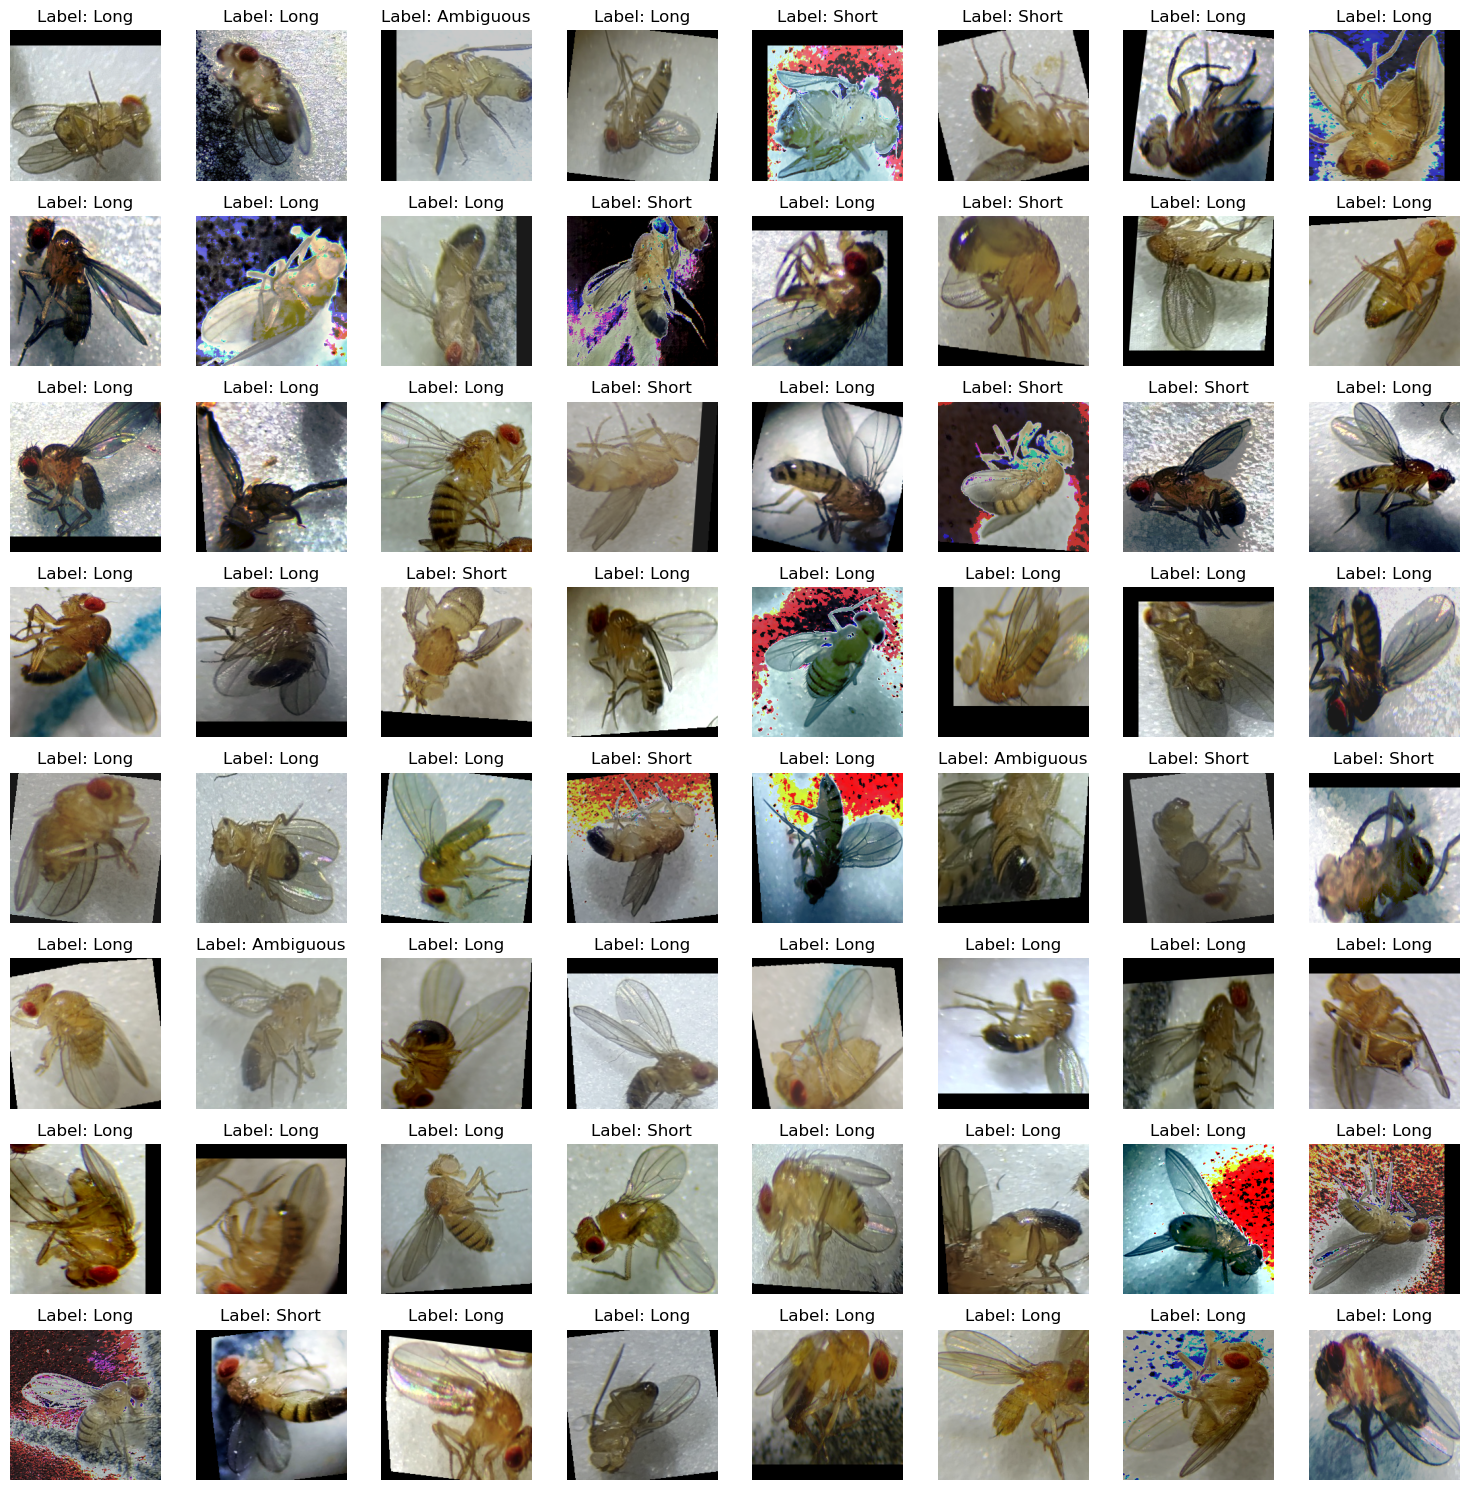

Epoch: 1/100, Batch: 0, 1/9
Epoch: 1/100, Batch: 1, 2/9
Epoch: 1/100, Batch: 2, 3/9
Epoch: 1/100, Batch: 3, 4/9
Epoch: 1/100, Batch: 4, 5/9
Epoch: 1/100, Batch: 5, 6/9
Epoch: 1/100, Batch: 6, 7/9
Epoch: 1/100, Batch: 7, 8/9
Epoch: 1/100, Batch: 8, 9/9
Validation - Loss: 0.9798, Accuracy: 46.09%
✓ 验证损失改进 -> 保存模型
Epoch: 2/100, Batch: 0, 1/9
Epoch: 2/100, Batch: 1, 2/9
Epoch: 2/100, Batch: 2, 3/9
Epoch: 2/100, Batch: 3, 4/9
Epoch: 2/100, Batch: 4, 5/9
Epoch: 2/100, Batch: 5, 6/9
Epoch: 2/100, Batch: 6, 7/9
Epoch: 2/100, Batch: 7, 8/9
Epoch: 2/100, Batch: 8, 9/9
Validation - Loss: 0.6896, Accuracy: 74.22%
✓ 验证损失改进 -> 保存模型
Epoch: 3/100, Batch: 0, 1/9
Epoch: 3/100, Batch: 1, 2/9
Epoch: 3/100, Batch: 2, 3/9
Epoch: 3/100, Batch: 3, 4/9
Epoch: 3/100, Batch: 4, 5/9
Epoch: 3/100, Batch: 5, 6/9
Epoch: 3/100, Batch: 6, 7/9
Epoch: 3/100, Batch: 7, 8/9
Epoch: 3/100, Batch: 8, 9/9
Validation - Loss: 0.5809, Accuracy: 78.91%
✓ 验证损失改进 -> 保存模型
Epoch: 4/100, Batch: 0, 1/9
Epoch: 4/100, Batch: 1, 2/9
Epoch

In [89]:
%matplotlib inline
import torch.nn as nn
from torchvision import models


def makeMorpherNet(printtoggle=False):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    num_features = model.fc.in_features
    
    # fc ：Dropout → Linear
    model.fc = nn.Sequential( # type: ignore
        nn.Dropout(p=0.7),               # 这里放 dropout
        nn.Linear(num_features, 3)
    )
    
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
    return model, lossfun, optimizer


batchsize = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if you use mac
# device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

train_loader, classes = loadTrain("./data/1210-403-cls", batchsize)

# 加载验证集用于早停
val_loader, _ = loadTest("./data/1210-403-cls", batchsize)

model, lossfun, optimizer = makeMorpherNet(False)

# 使用早停机制训练模型 (patience=n 表示n轮无改进后停止)
losses, accuracy, _, val_losses, val_accuracy = function2trainModel(
    model, device, train_loader, lossfun, optimizer, 
    val_loader=val_loader, patience=10, max_epochs=100
)

print("--------------------------")
print("Loss and accuracy in every iteration")
for i, (loss, acc) in enumerate(zip(losses, accuracy)):
    print(f"Iteration {i}, Train Loss: {loss:.2f}, Train Accuracy: {acc:.2f}%")
    if i < len(val_losses):
        print(f"           Val Loss: {val_losses[i]:.2f}, Val Accuracy: {val_accuracy[i]:.2f}%")

PATH = "./fly_morpher_resnet_1210_224.pth"
torch.save(model.state_dict(), PATH)


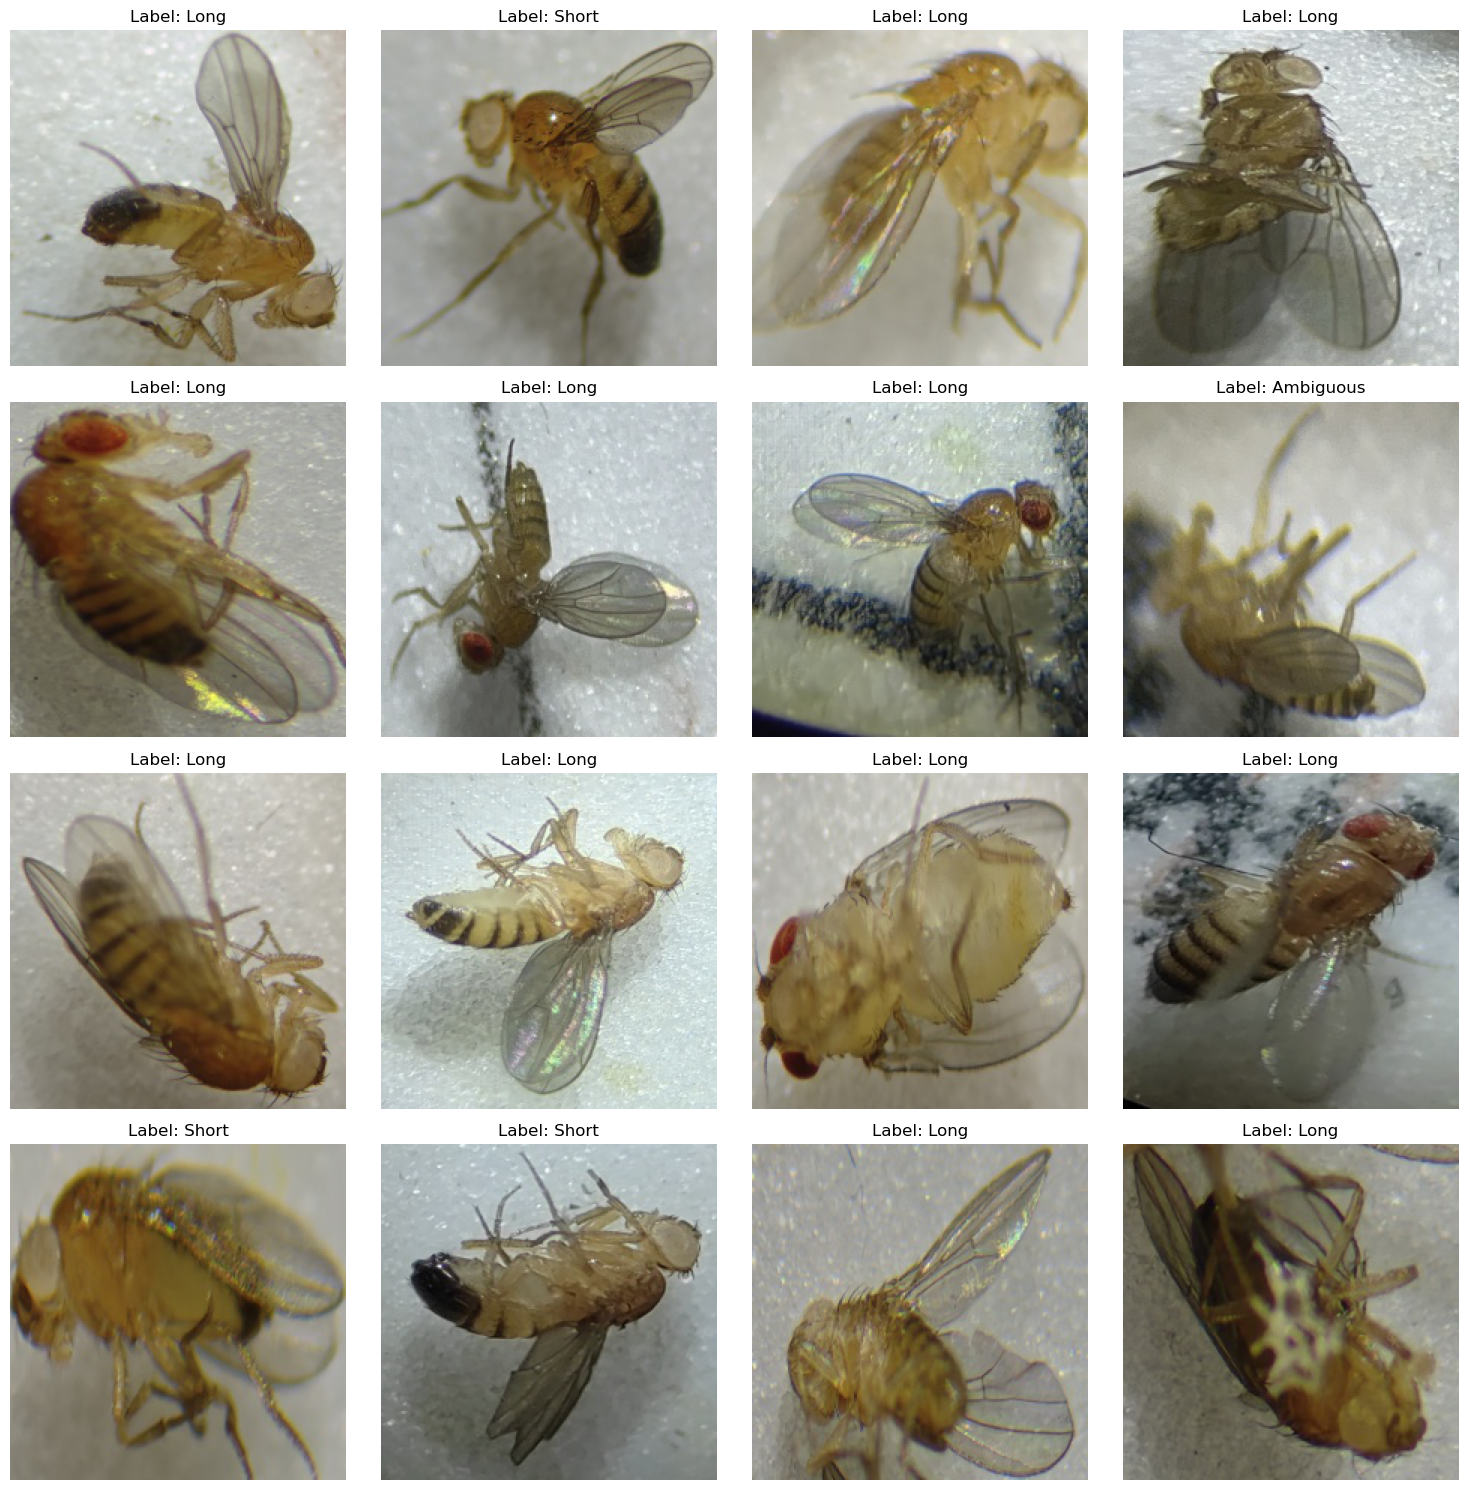

Ambiguous: 100.00%, Long: 91.67%, Short: 66.67%, total: 87.50%

Ambiguous: 50.00%, Long: 91.67%, Short: 100.00%, total: 87.50%

Ambiguous: 50.00%, Long: 90.99%, Short: 65.52%, 
Overall Accuracy: 84.72%

Ambiguous: 25.00%, Long: 91.82%, Short: 73.08%, 
Overall Recall: 84.72%


In [90]:
%matplotlib inline
batch_size = 16

model, lossfun, optimizer = makeMorpherNet(False)
PATH = "./fly_morpher_resnet_1210_224.pth"
model.load_state_dict(torch.load(PATH, weights_only=True))
test_loader, classes = loadTest("./data/1210-403-cls", batch_size)
n_classes = len(classes)

X, y = next(iter(test_loader))

model.eval()
## Test in one batch
with torch.no_grad():
    yHat = model(X)

    ##Step 1 Obtain predicted labels
    new_labels = torch.argmax(yHat, dim=1)

    ##Show first 32 predicted labels
    imshow_with_labels(X[:32], new_labels[:32], classes)

    # Step 2
    ##Calculate the accuracy for each category prediction, as well as the overall accuracy
    predicted_labels = new_labels
    true_labels = y

    precision_per_class = []
    for c in range(n_classes):
        mask_pred = predicted_labels == c
        correct = (mask_pred & (true_labels == c)).sum().item()
        total_pred = mask_pred.sum().item()
        try:
            precision = correct / total_pred * 100
            precision_per_class.append(precision)
        except ZeroDivisionError:
            precision_per_class.append(0)

    overall_accuracy = (predicted_labels == true_labels).float().mean().item() * 100

    # Print them to the screen.
    ## "happy:xx.xx%, neutral:xx.xx%, sad:xx.xx%, total:xx.xx%"
    for i, class_name in enumerate(classes):
        print(f"{class_name}: {precision_per_class[i]:.2f}%", end=", ")
    print(f"total: {overall_accuracy:.2f}%\n")

    # Step 3
    ##Calculate the recall for each category prediction, as well as the overall recall
    recall_per_class = []
    for c in range(n_classes):
        mask_true = true_labels == c
        correct = (mask_true & (predicted_labels == c)).sum().item()
        total_true = mask_true.sum().item()
        recall = (correct / total_true * 100) if total_true != 0 else 0.0
        recall_per_class.append(recall)

    overall_recall = (predicted_labels == true_labels).float().mean().item() * 100

    # Print them to the screen.
    ## "happy:xx.xx%, neutral:xx.xx%, sad:xx.xx%, total:xx.xx%"
    for i, class_name in enumerate(classes):
        print(f"{class_name}: {recall_per_class[i]:.2f}%", end=", ")
    print(f"total: {overall_recall:.2f}%\n")

## Get the accuracy and recall in full dataset
##Step 4
confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)

model.eval()

for X, y in test_loader:
    outputs = model(X)
    _, preds = torch.max(outputs, 1)
    for t, p in zip(y.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

total_correct = confusion_matrix.diag().sum().item()
total_samples = confusion_matrix.sum().item()
overall_accuracy_full = (total_correct / total_samples) * 100

precision_per_class_full = []
recall_per_class_full = []
for c in range(3):
    tp = confusion_matrix[c, c].item()
    sum_pred = confusion_matrix[:, c].sum().item()
    sum_true = confusion_matrix[c, :].sum().item()

    precision_full = (tp / sum_pred * 100) if sum_pred != 0 else 0.0
    recall_full = (tp / sum_true * 100) if sum_true != 0 else 0.0

    precision_per_class_full.append(precision_full)
    recall_per_class_full.append(recall_full)

for i, class_name in enumerate(classes):
    print(f"{class_name}: {precision_per_class_full[i]:.2f}%", end=", ")
print(f"\nOverall Accuracy: {overall_accuracy_full:.2f}%\n")

for i, class_name in enumerate(classes):
    print(f"{class_name}: {recall_per_class_full[i]:.2f}%", end=", ")
print(f"\nOverall Recall: {overall_accuracy_full:.2f}%")

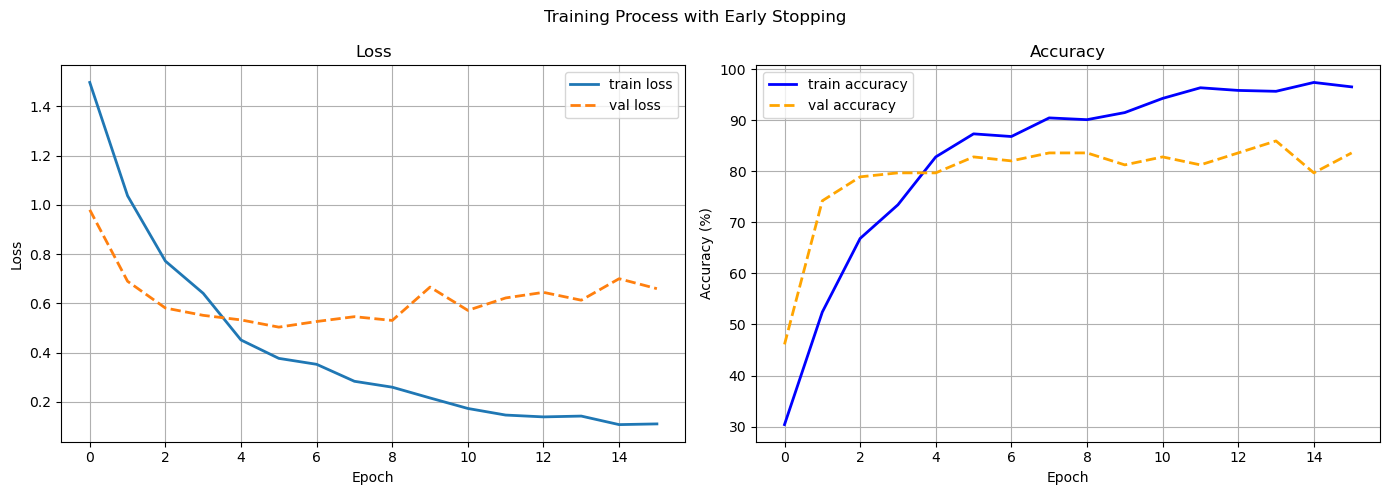

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the loss curve and accuracy curve in two subplots.
# Create sub figure.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Add title
fig.suptitle("Training Process with Early Stopping")

# Loss curve
ax[0].plot(losses, label="train loss", linewidth=2)
if len(val_losses) > 0:
    ax[0].plot(val_losses, label="val loss", linewidth=2, linestyle='--')
ax[0].legend()
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

# Accuracy curve
ax[1].plot(accuracy, label="train accuracy", color="blue", linewidth=2)
if len(val_accuracy) > 0:
    ax[1].plot(val_accuracy, label="val accuracy",
               color="orange", linewidth=2, linestyle='--')

ax[1].legend()
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].grid()

plt.tight_layout()
plt.show()

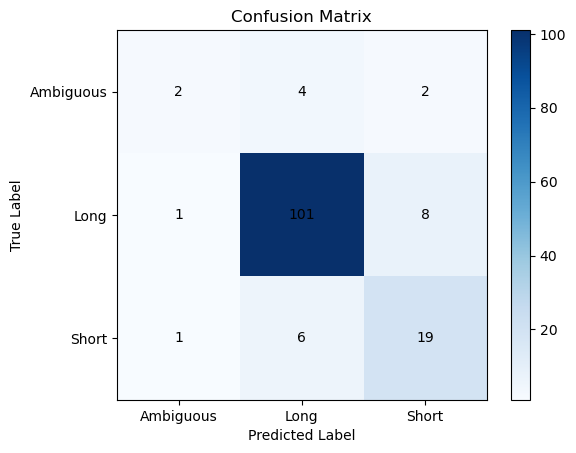

In [92]:
# Display the confusion matrix generated.
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)  # type: ignore
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)
plt.title("Confusion Matrix")
plt.colorbar()

# label the cells with the count of each class.
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(
            j, i, str(confusion_matrix[i, j].item()), ha="center", va="center")

plt.show()